# Clustering Crypto

In [51]:
# Initial imports
import pandas as pd
import hvplot.pandas
from pathlib import Path
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Data Preprocessing

In [7]:
# Loade the cryptocurrencies data
file_path = Path("Resources/crypto_data.csv")
crypto_df = pd.read_csv(file_path, index_col=0)
crypto_df.head(10)

CoinName Algorithm  IsTrading ProofType  TotalCoinsMined  \
42      42 Coin    Scrypt       True   PoW/PoS     4.199995e+01   
365     365Coin       X11       True   PoW/PoS              NaN   
404     404Coin    Scrypt       True   PoW/PoS     1.055185e+09   
611   SixEleven   SHA-256       True       PoW              NaN   
808         808   SHA-256       True   PoW/PoS     0.000000e+00   
1337  EliteCoin       X13       True   PoW/PoS     2.927942e+10   
2015  2015 coin       X11       True   PoW/PoS              NaN   
BTC     Bitcoin   SHA-256       True       PoW     1.792718e+07   
ETH    Ethereum    Ethash       True       PoW     1.076842e+08   
LTC    Litecoin    Scrypt       True       PoW     6.303924e+07   

     TotalCoinSupply  
42                42  
365       2300000000  
404        532000000  
611           611000  
808                0  
1337    314159265359  
2015               0  
BTC         21000000  
ETH                0  
LTC         84000000

In [9]:
# Keep only cryptocurrencies that are on trading
clean_crypto_df = crypto_df.loc[crypto_df['IsTrading']==True]
clean_crypto_df.sample(10)

CoinName    Algorithm  IsTrading ProofType  TotalCoinsMined  \
XCR                 Crypti     Multiple       True       PoS     1.000000e+08   
TRC              TerraCoin      SHA-256       True       PoW     2.293540e+07   
RBTC         Smart Bitcoin      SHA-256       True       PoW     0.000000e+00   
STAX              Staxcoin       Scrypt       True   PoW/PoS              NaN   
KRM                  Karma      Groestl       True       PoS              NaN   
GRFT      Graft Blockchain  CryptoNight       True   PoW/PoS              NaN   
808                    808      SHA-256       True   PoW/PoS     0.000000e+00   
USC   Ultimate Secure Cash      SHA-256       True       PoS     1.034311e+07   
BLC              BlakeCoin        Blake       True       PoW     2.335679e+07   
OPES                  Opes       Argon2       True       PoW              NaN   

     TotalCoinSupply  
XCR                0  
TRC         42000000  
RBTC        20999764  
STAX        43500000  
KRM       3000000000  
GRFT      1844674400  
808                0  
USC        200084200  
BLC       7000000000  
OPES        52000000

In [14]:
# Keep only cryptocurrencies with a working algorithm
# A non working algorithm is recognized by 'N/A' status, so drop all entries with 'N/A'
clean_crypto_df = clean_crypto_df.loc[clean_crypto_df['Algorithm'] != 'N/A']
clean_crypto_df.head(10)

CoinName Algorithm  IsTrading ProofType  TotalCoinsMined  \
42      42 Coin    Scrypt       True   PoW/PoS     4.199995e+01   
365     365Coin       X11       True   PoW/PoS              NaN   
404     404Coin    Scrypt       True   PoW/PoS     1.055185e+09   
611   SixEleven   SHA-256       True       PoW              NaN   
808         808   SHA-256       True   PoW/PoS     0.000000e+00   
1337  EliteCoin       X13       True   PoW/PoS     2.927942e+10   
2015  2015 coin       X11       True   PoW/PoS              NaN   
BTC     Bitcoin   SHA-256       True       PoW     1.792718e+07   
ETH    Ethereum    Ethash       True       PoW     1.076842e+08   
LTC    Litecoin    Scrypt       True       PoW     6.303924e+07   

     TotalCoinSupply  
42                42  
365       2300000000  
404        532000000  
611           611000  
808                0  
1337    314159265359  
2015               0  
BTC         21000000  
ETH                0  
LTC         84000000

In [18]:
# Remove the "IsTrading" column
clean_crypto_df = clean_crypto_df.drop(columns='IsTrading')
clean_crypto_df.head(5)


CoinName Algorithm ProofType  TotalCoinsMined TotalCoinSupply
42     42 Coin    Scrypt   PoW/PoS     4.199995e+01              42
365    365Coin       X11   PoW/PoS              NaN      2300000000
404    404Coin    Scrypt   PoW/PoS     1.055185e+09       532000000
611  SixEleven   SHA-256       PoW              NaN          611000
808        808   SHA-256   PoW/PoS     0.000000e+00               0

In [22]:
# Remove rows with at least 1 null value

# Check if there are nulls
clean_crypto_df.isnull().mean()

# drop nulls
clean_crypto_df = clean_crypto_df.dropna()

In [28]:
# Remove rows with cryptocurrencies without coins mined
clean_crypto_df = clean_crypto_df.loc[clean_crypto_df['TotalCoinsMined'] != 0]
clean_crypto_df = clean_crypto_df.loc[clean_crypto_df['TotalCoinsMined'] != 'NaN']


In [33]:
# Fetch the cryptocurrencies names prior to drop them from crypto_df
crypto_names = clean_crypto_df['CoinName']
crypto_names.head(10)

42               42 Coin
404              404Coin
1337           EliteCoin
BTC              Bitcoin
ETH             Ethereum
LTC             Litecoin
DASH                Dash
XMR               Monero
ETC     Ethereum Classic
ZEC                ZCash
Name: CoinName, dtype: object

In [37]:
# Remove the cryptocurrency name since it's not going to be used on the clustering algorithm
clean_crypto_df = clean_crypto_df.drop(columns='CoinName')
clean_crypto_df.head()

Algorithm ProofType  TotalCoinsMined TotalCoinSupply
42      Scrypt   PoW/PoS     4.199995e+01              42
404     Scrypt   PoW/PoS     1.055185e+09       532000000
1337       X13   PoW/PoS     2.927942e+10    314159265359
BTC    SHA-256       PoW     1.792718e+07        21000000
ETH     Ethash       PoW     1.076842e+08               0

In [40]:
# Create dummies variables for text features
X = pd.get_dummies(clean_crypto_df, columns=['Algorithm', 'ProofType'])
X.head(5)

TotalCoinsMined TotalCoinSupply  Algorithm_1GB AES Pattern Search  \
42       4.199995e+01              42                                 0   
404      1.055185e+09       532000000                                 0   
1337     2.927942e+10    314159265359                                 0   
BTC      1.792718e+07        21000000                                 0   
ETH      1.076842e+08               0                                 0   

      Algorithm_536  Algorithm_Argon2d  Algorithm_BLAKE256  Algorithm_Blake  \
42                0                  0                   0                0   
404               0                  0                   0                0   
1337              0                  0                   0                0   
BTC               0                  0                   0                0   
ETH               0                  0                   0                0   

      Algorithm_Blake2S  Algorithm_Blake2b  Algorithm_C11  ...  \
42                    0                  0              0  ...   
404                   0                  0              0  ...   
1337                  0                  0              0  ...   
BTC                   0                  0              0  ...   
ETH                   0                  0              0  ...   

      ProofType_PoW/PoS  ProofType_PoW/PoS   ProofType_PoW/PoW  \
42                    1                   0                  0   
404                   1                   0                  0   
1337                  1                   0                  0   
BTC                   0                   0                  0   
ETH                   0                   0                  0   

      ProofType_PoW/nPoS  ProofType_Pos  ProofType_Proof of Authority  \
42                     0              0                             0   
404                    0              0                             0   
1337                   0              0                             0   
BTC                    0              0                             0   
ETH                    0              0                             0   

      ProofType_Proof of Trust  ProofType_TPoS  \
42                           0               0   
404                          0               0   
1337                         0               0   
BTC                          0               0   
ETH                          0               0   

      ProofType_Zero-Knowledge Proof  ProofType_dPoW/PoW  
42                                 0                   0  
404                                0                   0  
1337                               0                   0  
BTC                                0                   0  
ETH                                0                   0  

[5 rows x 100 columns]

In [42]:
# Standardize data
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[-0.11674788, -0.15286468, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.09358885, -0.14499604, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [ 0.52587231,  4.4937636 , -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       ...,
       [-0.09523411, -0.13215444, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.11658774, -0.15255408, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.11674507, -0.15284989, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ]])

### Reducing Dimensions Using PCA

In [52]:
# Use PCA to reduce dimension to 3 principal components

# Initialize PCA model
pca = PCA(n_components=3)

# Deploy model
X_pca = pca.fit_transform(X_scaled)

In [88]:
# Create a DataFrame with the principal components data
pcs_df = pd.DataFrame(data=X_pca, columns=['PC 1', "PC 2", "PC 3"], index= clean_crypto_df.index)
pcs_df.head(5)

PC 1      PC 2      PC 3
42   -0.334203  0.924751 -0.402677
404  -0.317519  0.925098 -0.402899
1337  2.299081  1.611627 -0.553800
BTC  -0.143341 -1.285613  0.188118
ETH  -0.148488 -1.980949  0.312677

### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [89]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range ok k values

for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot

elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

Running K-Means with `k=4`

In [90]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=5)

# Fit the model
model.fit(pcs_df)

# Predict clusters
predictions = model.predict(pcs_df)
print(predictions)


[1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0
 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 0
 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1
 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1
 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0
 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1
 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1
 0 0 1 0 0 0 0 1 1 3 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0
 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 0
 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1
 0 0 0 1 1 1 0 1 0 1 0 1 

In [93]:
# Creating a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pd.DataFrame({
    "Algorithm": clean_crypto_df.Algorithm,
    "ProofType": clean_crypto_df.ProofType,
    "TotalCoinsMined": clean_crypto_df.TotalCoinsMined,
    "TotalCoinSupply": clean_crypto_df.TotalCoinSupply,
    "PC 1": pcs_df['PC 1'],
    "PC 2": pcs_df['PC 2'],
    "PC 3": pcs_df['PC 3'],
    "CoinName": crypto_names,
    "Class": model.labels_, 
    },
)
clustered_df.head()



Algorithm ProofType  TotalCoinsMined TotalCoinSupply      PC 1      PC 2  \
42      Scrypt   PoW/PoS     4.199995e+01              42 -0.334203  0.924751   
404     Scrypt   PoW/PoS     1.055185e+09       532000000 -0.317519  0.925098   
1337       X13   PoW/PoS     2.927942e+10    314159265359  2.299081  1.611627   
BTC    SHA-256       PoW     1.792718e+07        21000000 -0.143341 -1.285613   
ETH     Ethash       PoW     1.076842e+08               0 -0.148488 -1.980949   

          PC 3   CoinName  Class  
42   -0.402677    42 Coin      1  
404  -0.402899    404Coin      1  
1337 -0.553800  EliteCoin      1  
BTC   0.188118    Bitcoin      0  
ETH   0.312677   Ethereum      0

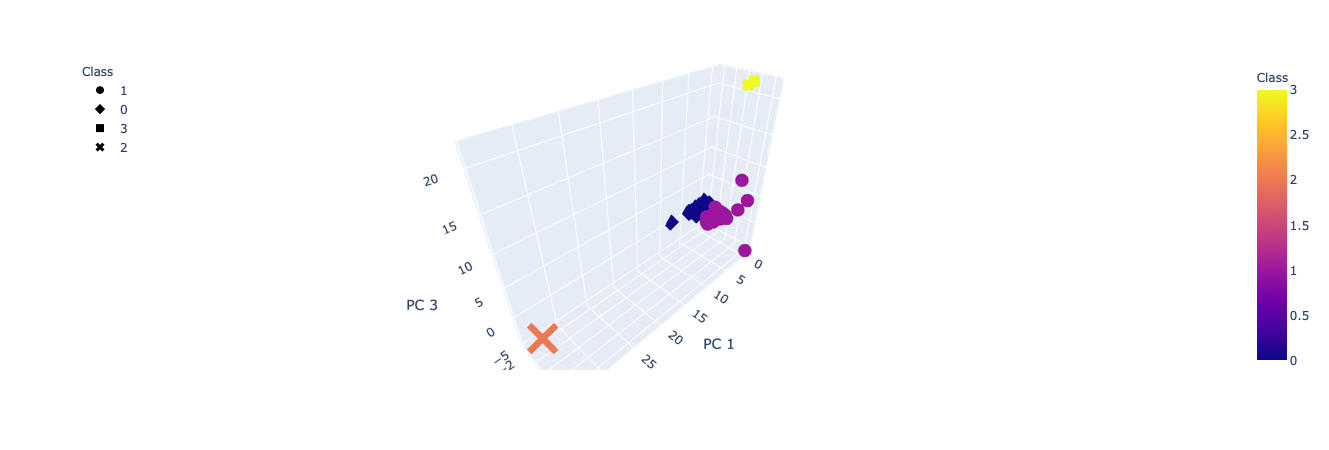

In [98]:
### Visualizing Results

#### 3D-Scatter with Clusters
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    hover_name='CoinName',
    hover_data= ['Algorithm'],
    color="Class",
    symbol="Class",
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [ ]:
#### Table of Tradable Cryptocurrencies

In [101]:
# Table with tradable cryptos
columns = ['CoinName', 'Algorithm', 'ProofType', 'TotalCoinSupply', 'TotalCoinsMined', 'Class']
table = clustered_df.hvplot.table(columns)
table


:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

In [104]:
# Print the total number of tradable cryptocurrencies
tradable_currencies = table.shape[0]
print(f'The total number of tradable cryptocurrencies is {tradable_currencies}')


The total number of tradable cryptocurrencies is 533


#### Scatter Plot with Tradable Cryptocurrencies

In [108]:
# Scale data to create the scatter plot
clustered_df['TotalCoinsMined'] = clustered_df['TotalCoinsMined'] / 1000000000
clustered_df['TotalCoinSupply'] = clustered_df['TotalCoinSupply'] / 1000000000

In [110]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
clustered_df.hvplot(
    kind="scatter", 
    x="TotalCoinsMined", 
    y="TotalCoinSupply", 
    c='Class', 
    colormap="Inferno_r", 
    hover_cols=['CoinName']
)

:Scatter   [TotalCoinsMined]   (TotalCoinSupply,Class,CoinName)